# Project: Multivariate Analysis - Higgs Challenge

This sheet is not a regular exercise, but rather a little
"Project" to enhance your skills acquired during the exercises.
The project is desiccated specifically to the use of multivariate
analysis techniques. 

A (rather complicated) data set is provided - it is a 
subset of data released by the ATLAS experiment at the
Large Hadron Collider LHC at CERN under the title "Learning
to discover: the Higgs boson machine learning challenge".
The related document is provided on our web page; the full
information is given at
[https://opendata.cern.ch/record/329](https://opendata.cern.ch/record/329),
a web page hosted by CERN making available to the public
LHC data for educational projects and research. 

The MVA project will be centred around methods to search for 
the very rare signal of Higgs-production in the data of an LHC 
experiment. The released "data" in fact consist of simulated data of 
a complex signal, decays of a Higgs boson to two $\tau$ leptons,
and the sum of all background reactions. Among the many combinations
of possible decay modes of a pair of $\tau$ leptons the 
"Higgs challenge" concentrates on the dominant one: one $\tau$ 
decays to hadrons and a neutrino ($\tau_h$), and  the other one to an electron 
or muon and two neutrinos ($\tau_{\ell}$).
The short document {\em atlas-higgs-challenge-2014.pdf} describes
the problem and gives background-information on the input data.
Roughly speaking, these fall into two categories: primary or
PRImitive variables (indicated by the prefix PRI) are raw quantities 
of the identified objects in the event, and DERived variables
(prefix DER) are quantities derived from these by the ATLAS
physicists to be used in their own multivariate analysis, the final
results of which were published in spring 2015. The challenge is, of
course: try to beat them!

For the purpose of this data-analysis project, no deep understanding
of the underlying physics is required, simply take the data
as an example of a complex "multivariate data-set". 

The original data set consists of 250'000 simulated events
as the "training sample" for multivariate algorithms classified
as signal (i.e. a true H$\to\tau\tau \to \tau_h \tau_\ell$ event)
and background reactions. Weights are provided with each event 
such that the sum of weights corresponds to the same total number 
of events observed by the ATLAS experiment in the year 2012.
An independent "validation sample" with 450'000 events to
measure the performance of any proposed algorithm is also 
privided. To avoid "cheating", originally there was no classification
of these events, this was added later and now allows everybody
to compare the performance of any newly developed multivariate 
classifier.

To set the scale: a record number of 1'785 teams participated 
in the Higgs challenge conducted by Kaggle 
(see [https://www.kaggle.com](https://www.kaggle.com)).
The winner achieved a score of 3.81; there were only tiny differences
in the top league, rank four still scored 3.72. The real competitiion 
is over now, but we will use the data for the final data classifcation
project of the course "Moderne Methoden der Datenanalye", and it
is your chance to combine what you've learned in the course 
with your own creativity ...




This Jupyter Notebook shows some example code of how to train and evaluate a classifier for the Higgs Challenge.
It will work you through the step of extracting the data from the ROOT trees, preparing the data, creating a model, training the model and to finally analyse and summarise the results.


In [1]:
import numpy as np

from sklearn.utils import shuffle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow

import ROOT

2024-07-02 15:12:30.601930: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-02 15:12:30.602863: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 15:12:30.606541: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 15:12:30.655866: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 15:12:31.569315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

Welcome to JupyROOT 6.28/10


We are going to use ROOT [RDataframes](https://root.cern/doc/master/classROOT_1_1RDataFrame.html) as they provide an easy to use interface for transforming ROOT trees into numpy arrays and also allow to easily reconstruct additional variables and to make histograms.

In [2]:
RDF = ROOT.ROOT.RDataFrame

From the `atlas-higgs-challenge-2014-v2_part.root`we are going to use the 'signal' and 'background' trees for the training of our models and the 'validation' tree for evaluation.
Let's define a RDataFrame for each of those three trees:

In [6]:
signal_tree_name = 'signal'
background_tree_name = 'background'
test_tree_name = 'validation'
file_name = 'atlas-higgs-challenge-2014-v2_part.root'

rdf_signal = RDF(signal_tree_name, file_name)
rdf_bkg = RDF(background_tree_name, file_name)
rdf_test = RDF(test_tree_name, file_name)

RDataFrames allow to [define](https://root.cern.ch/doc/master/df012__DefinesAndFiltersAsStrings_8py.html) additional variables in python using C++ syntax, which will be compiled at runtime.
For example, if one wanted to reconstruct the transverse mass of the lepton and the leading jet in the event, one could use the following code:

In [7]:
reconstruct_transverse_lepton_jet_mass = '''

float lep_px = PRI_lep_pt * TMath::Cos(PRI_lep_phi);
float lep_py = PRI_lep_pt * TMath::Sin(PRI_lep_phi);
float jet_px = PRI_jet_leading_pt * TMath::Cos(PRI_jet_leading_phi);
float jet_py = PRI_jet_leading_pt * TMath::Sin(PRI_jet_leading_phi);

//calculate angle between jet and lepton
float cos_theta = (lep_px*jet_px + lep_py*jet_py) / PRI_lep_pt / PRI_jet_leading_pt;

return PRI_lep_pt * PRI_jet_leading_pt * (1 - cos_theta);
'''

The variable is then inserted in the RDataFrame using the `Define` method:

In [8]:
rdf = rdf_signal.Define('transverse_lepton_jet_mass', reconstruct_transverse_lepton_jet_mass)

For illustration, let's also create a histogram and fill the newly defined variable with it.

In [9]:
model = ROOT.RDF.TH1DModel('h', 'h', 40, 0, 100)

h1 = rdf.Histo1D(model, 'transverse_lepton_jet_mass')
h2 = rdf.Histo1D(model, 'PRI_jet_leading_pt')

RDataFrame will create histograms lazily. This means calling the `Histo1D` method will return a ResultPointer object. However, it won't fill the histogram directly. Only once the pointer is accessed via for example the `Draw` method, the histogram will be filled.
This has the advantage, that one can define multiple histograms and all of them are filled simultaneously once the first is accessed.
If you run the code below, it will take a short amount of time because internally ROOT will loop over the tree and fill the histograms.

In [10]:
canvas = ROOT.TCanvas()
h1.Draw('hist')
canvas.SaveAs('hist1.pdf')

Info in <TCanvas::Print>: pdf file hist1.pdf has been created


The code below will now execute almost instantly as the histogram 'h2' is already filled.

In [11]:
canvas = ROOT.TCanvas()
h2.Draw('hist')
canvas.SaveAs('hist2.pdf')

Info in <TCanvas::Print>: pdf file hist2.pdf has been created


Let's define this variable for all our RDataFrames, so we can use it in the training later.

In [12]:
rdf_signal = rdf_signal.Define('transverse_lepton_jet_mass', reconstruct_transverse_lepton_jet_mass)
rdf_bkg = rdf_bkg.Define('transverse_lepton_jet_mass', reconstruct_transverse_lepton_jet_mass)
rdf_test = rdf_test.Define('transverse_lepton_jet_mass', reconstruct_transverse_lepton_jet_mass)

For the training of our models we first need some input variables. We can get a list of all available variables in our RDataFrame with the method [GetColumnNames](https://root.cern/doc/master/classROOT_1_1RDF_1_1RInterface.html#a951fe60b74d3a9fda37df59fd1dac186):

In [13]:
columns = [col for col in rdf_signal.GetColumnNames()]
print(columns)

['DER_deltaeta_jet_jet', 'DER_deltar_tau_lep', 'DER_lep_eta_centrality', 'DER_mass_MMC', 'DER_mass_jet_jet', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_met_phi_centrality', 'DER_prodeta_jet_jet', 'DER_pt_h', 'DER_pt_ratio_lep_tau', 'DER_pt_tot', 'DER_sum_pt', 'EventId', 'KaggleSet', 'KaggleWeight', 'Label', 'PRI_jet_all_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_leading_pt', 'PRI_jet_num', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_subleading_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_lep_pt', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_tau_pt', 'Weight', 'transverse_lepton_jet_mass']


In this example we will only use the following list of five variables. 
Feel free to experiment with more and different variables in your own code.

In [14]:
input_columns = ["DER_mass_MMC", "DER_mass_transverse_met_lep", "DER_mass_vis", "DER_pt_h", "transverse_lepton_jet_mass"]

Most machine learning libraries in python expect their input in the form of numpy arrays. RDataFrames have the convenient method [AsNumy](https://indico.cern.ch/event/775679/contributions/3244724/attachments/1767054/2869505/RDataFrame.AsNumpy.pdf) which allows to transform them into numpy arrays. It will return a dictionary of the form `{column_name : numpy.array}`.
Execute the code below to see what the method does:

In [15]:
res = rdf_signal.AsNumpy(columns=input_columns)
print(res)

{'DER_mass_MMC': ndarray([138.47 , 148.754, 154.916, ..., 128.498, 151.113, 104.21 ],
        dtype=float32), 'DER_mass_transverse_met_lep': ndarray([51.655, 28.862, 10.418, ..., 18.588, 70.106, 18.268],
        dtype=float32), 'DER_mass_vis': ndarray([ 97.827, 107.782,  94.714, ...,  69.903,  93.991,  58.438],
        dtype=float32), 'DER_pt_h': ndarray([ 27.98 , 106.13 ,  29.169, ...,  54.601,   4.145,  80.275],
        dtype=float32), 'transverse_lepton_jet_mass': ndarray([ 6.8237383e+03,  2.0909959e+04,  6.1837223e+01, ...,
          7.7430044e+03, -9.3656383e+04,  2.3110034e+03], dtype=float32)}


Before training any classifier, it is helpful to have a look at the variables and how they are distributed for signal and background. In the following we will make a histogram for signal and background for all our input variables and plot them.

Feel free to implement you own plotting functions using `matplotlib` or similar python libraries to replace the ROOT plots below.

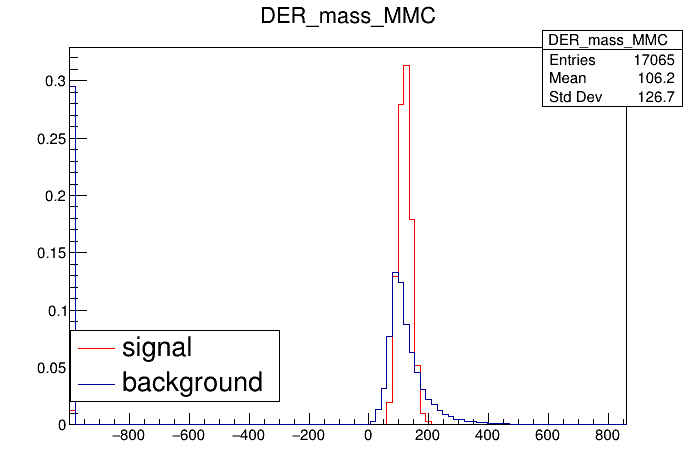

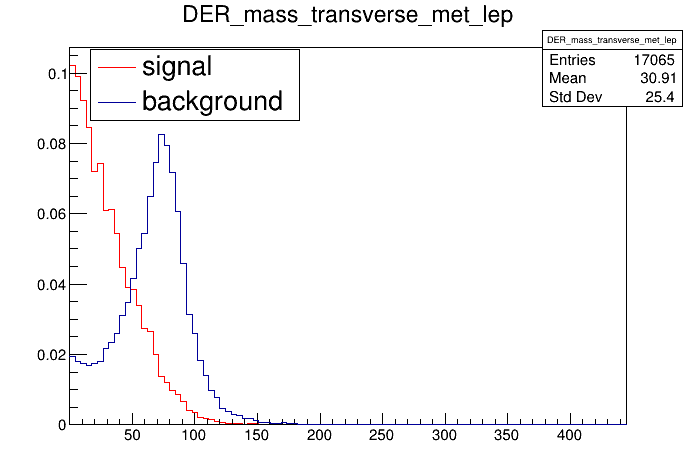

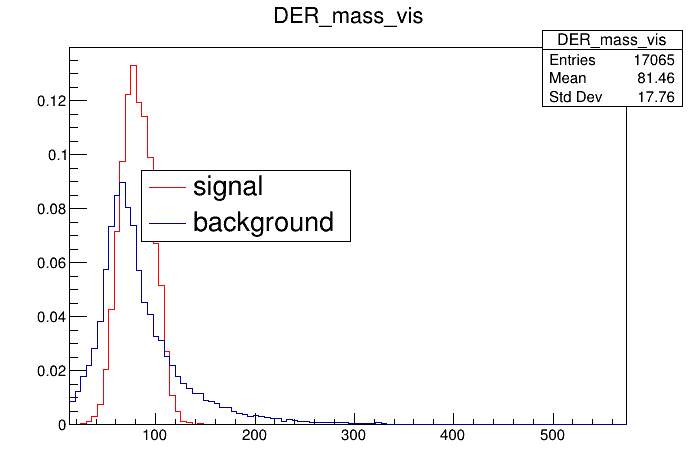

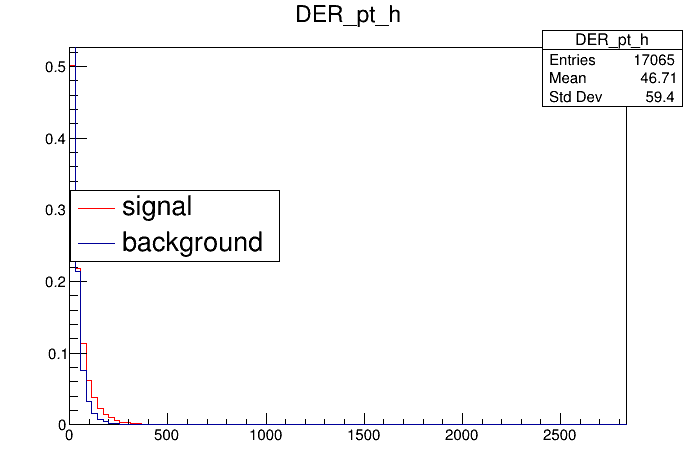

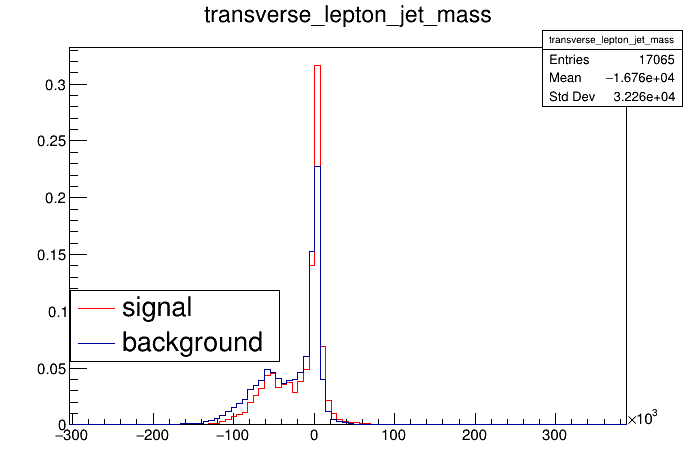

In [16]:
hists = list()
for col in input_columns:
    # we just pick the min and max of the variables as the binning range.
    # and use an equal-distant binning.
    # This might not make sense for all variables. Then you might need to adjust the binning.
    try:
        xmin = min(res[col])
        xmax = max(res[col])
    except TypeError:
        continue
    model = ROOT.RDF.TH1DModel(col, col, 100, xmin, xmax)
    h_s = rdf_signal.Histo1D(model, col, 'Weight')
    h_b = rdf_bkg.Histo1D(model, col, 'Weight')
    hists.append((h_s, h_b))

# define some dummy list to fill in the canvases and legends, 
# because ROOT will otherwise destroy the objects 
# after the loop and won't draw anything.
canvases = list()
legends = list()
for idx, hist in enumerate(hists):
    canvas = ROOT.TCanvas(f'1D_{idx}')
    hist[0].SetLineColor(ROOT.kRed)
    
    # we are only interested to see how the shapes differ between signal and background
    # therefore we normalize the distributions to 1.
    hist[0].Scale(1/hist[0].Integral())
    hist[1].Scale(1/hist[1].Integral())
    
    hist[0].Draw('hist')
    hist[1].Draw('histsame')
    legend = ROOT.TLegend()
    legend.AddEntry(hist[0].GetPtr(), 'signal', 'l')
    legend.AddEntry(hist[1].GetPtr(), 'background', 'l')
    legend.Draw('same')
    legends.append(legend)
    
    canvas.Modified()
    canvas.Update()
    canvas.Draw()
    canvases.append(canvas)

It is also useful to look at 2D distributions to see how the variables are correlated with each other. Note, to make the plots look nicer you should adjust the binning and the bin ranges for each distribution.

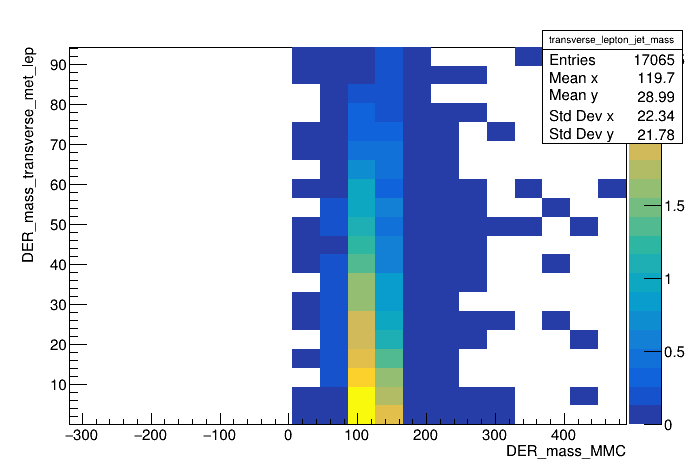

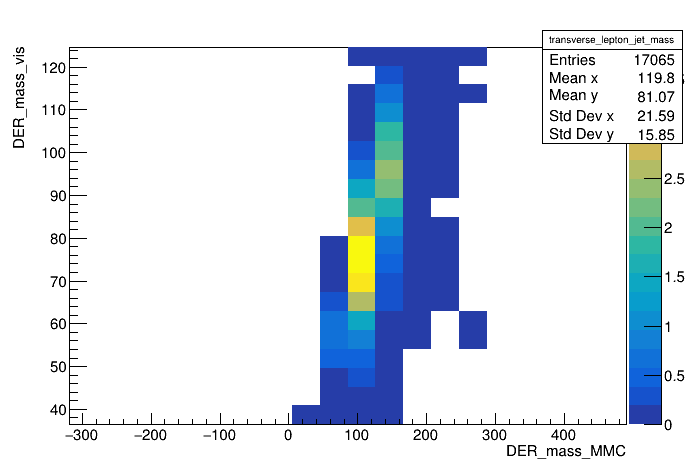

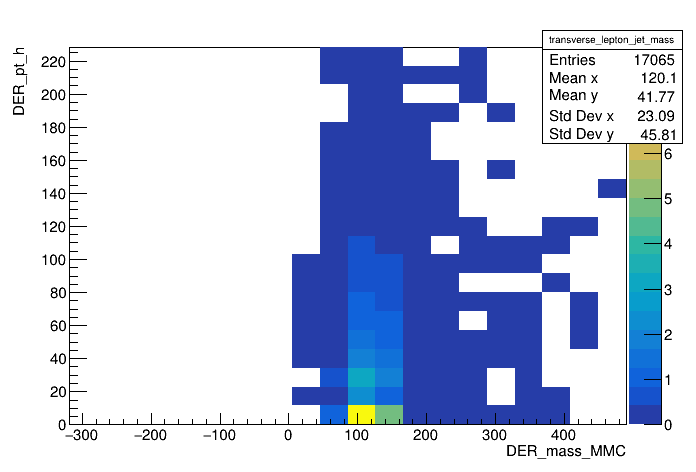

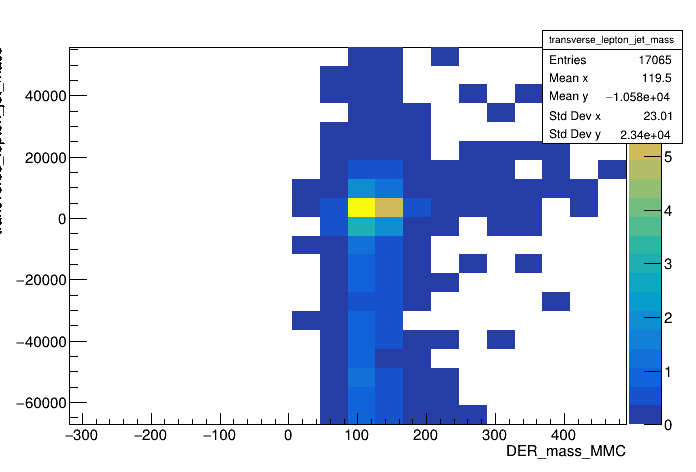

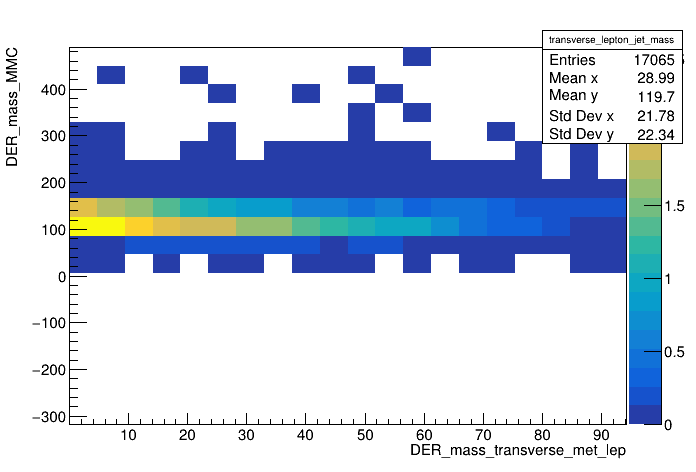

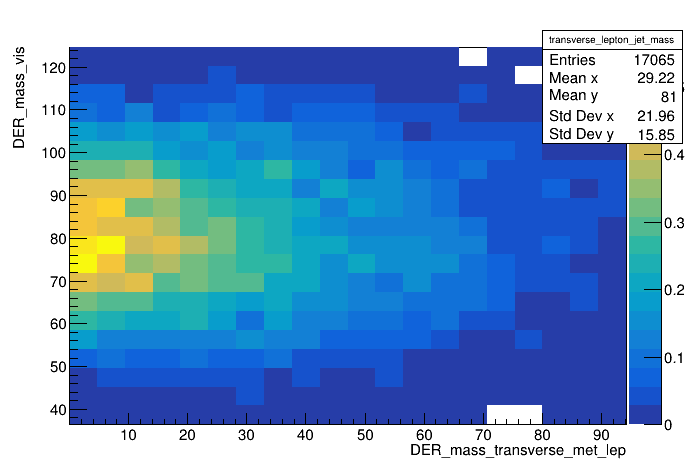

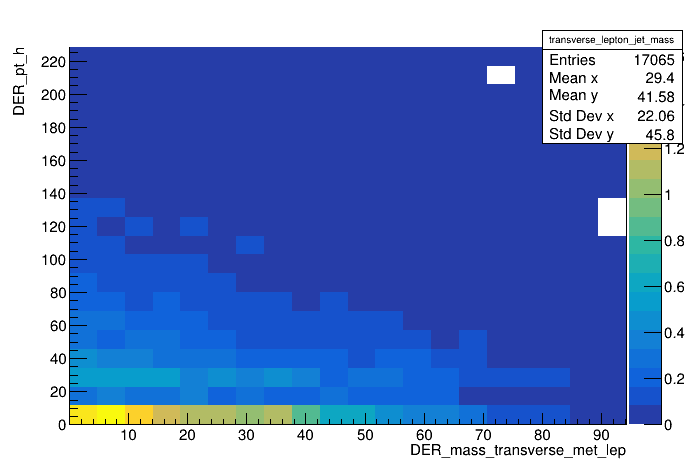

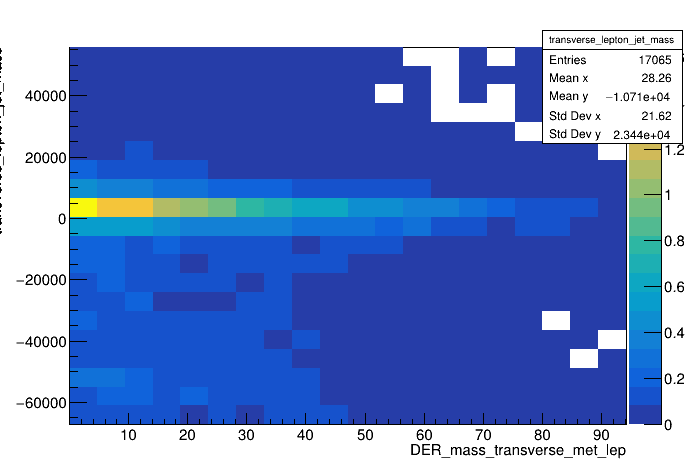

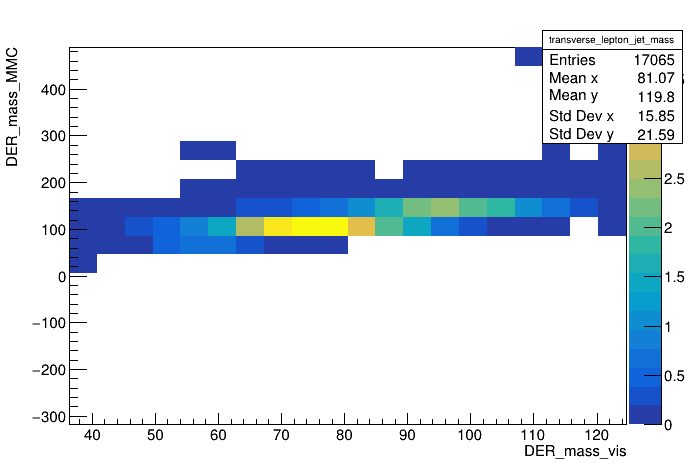

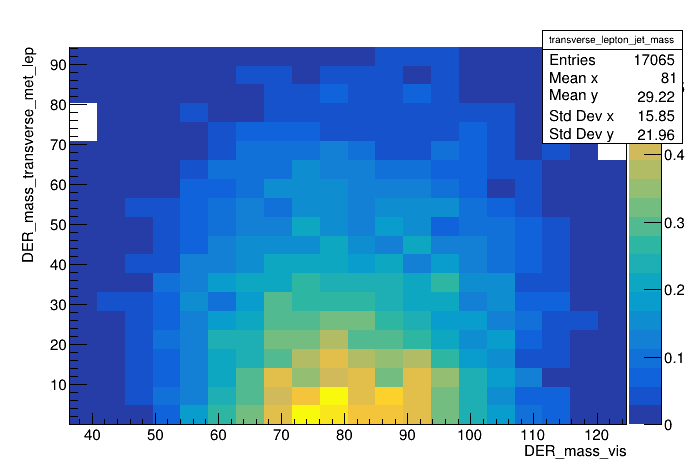

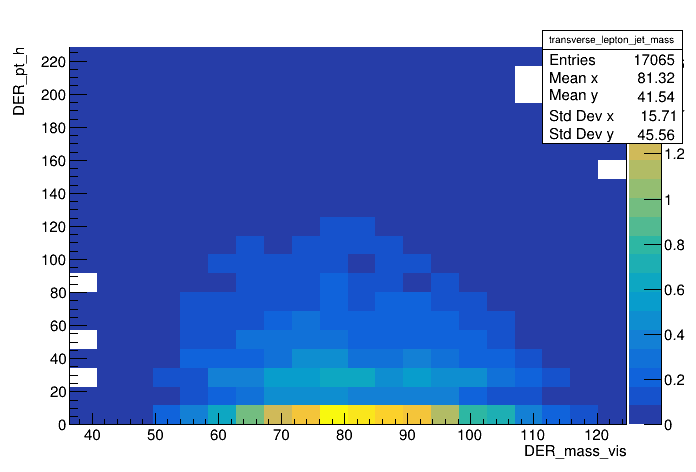

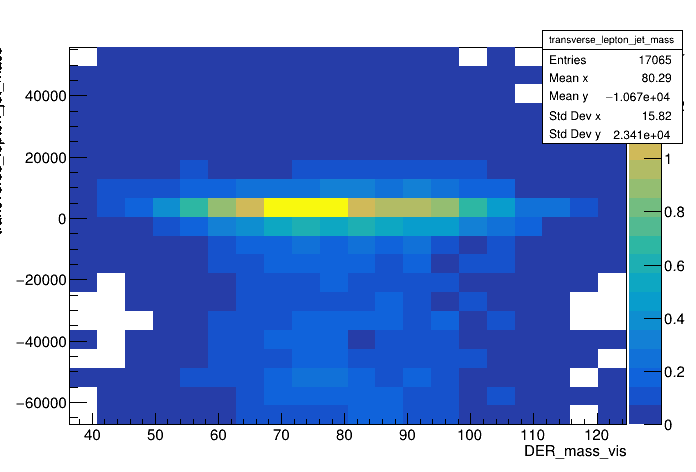

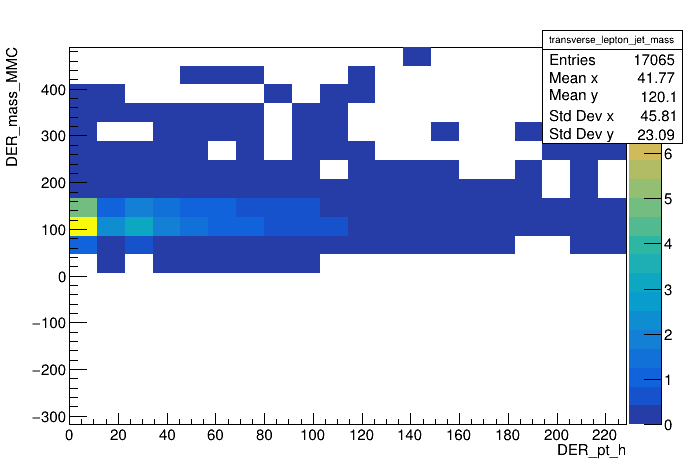

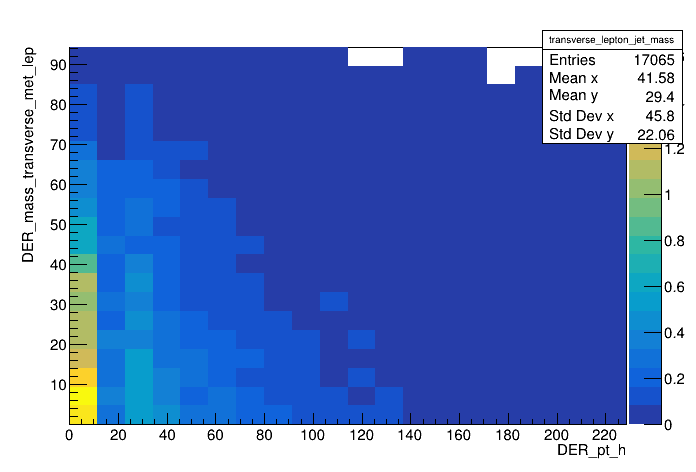

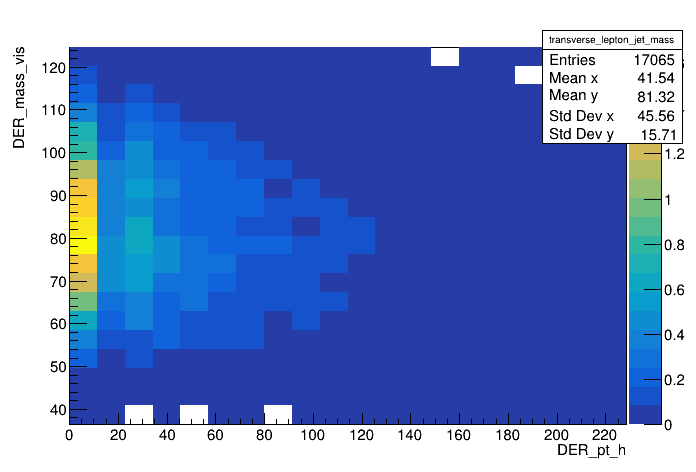

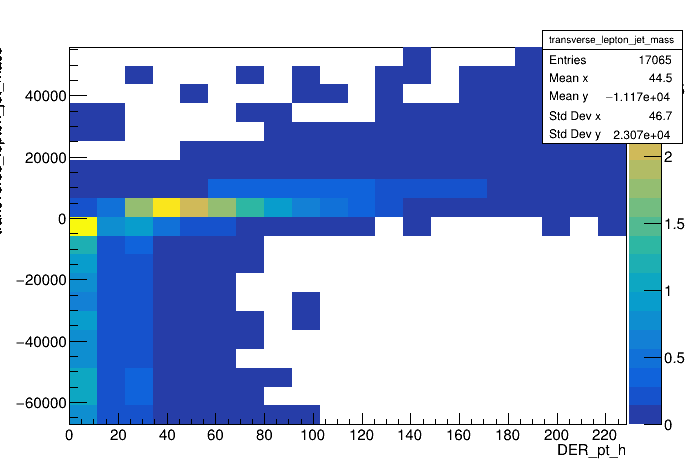

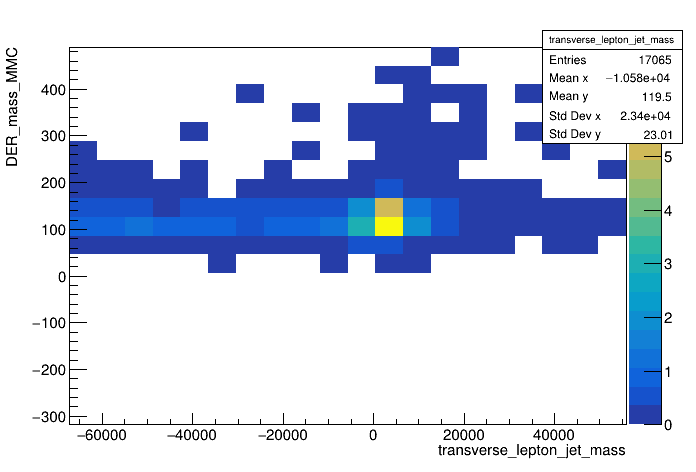

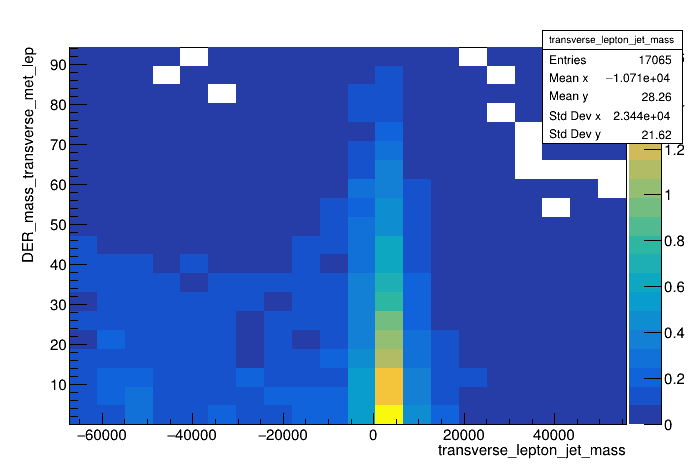

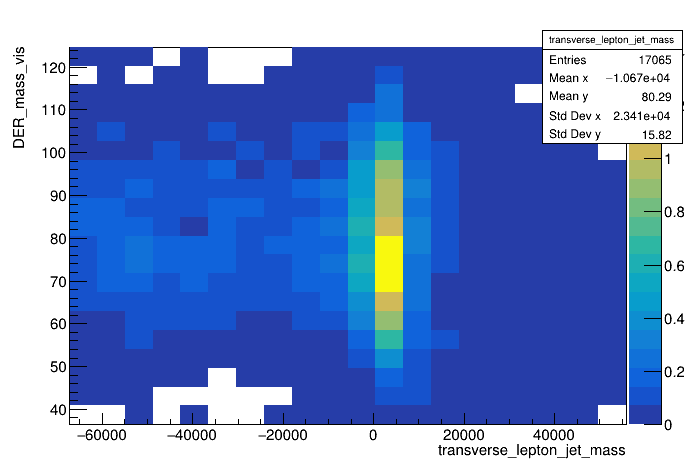

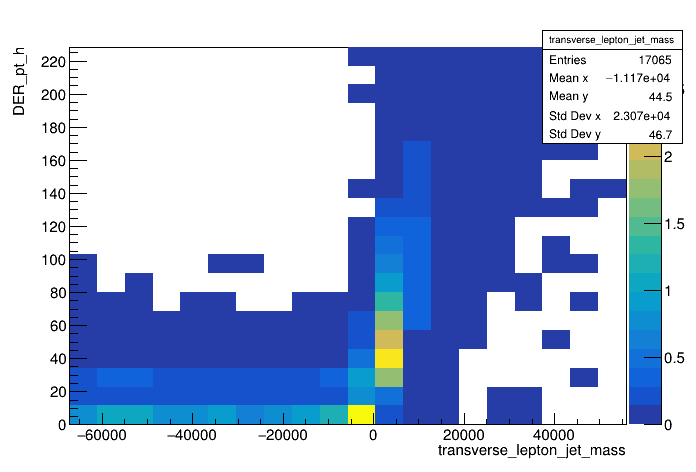

In [17]:
import itertools as it

perms = it.permutations(input_columns, 2)

hists = list()
for xvar, yvar in perms:
    try:
        xs = res[xvar]
        xmin = max(np.mean(xs) - 2*np.std(xs), min(xs))
        xmax = min(np.mean(xs) + 2*np.std(xs), max(xs))
        ys = res[yvar]
        ymin = max(np.mean(ys) - 2*np.std(ys), min(ys))
        ymax = min(np.mean(ys) + 2*np.std(ys), max(ys))
    except TypeError as e:
        continue
        
    model = ROOT.RDF.TH2DModel(col, col, 20, xmin, xmax, 20, ymin, ymax)
    h = rdf_signal.Histo2D(model, xvar, yvar, 'Weight')
    h.GetXaxis().SetTitle(xvar)
    h.GetYaxis().SetTitle(yvar)
    hists.append(h)

# don't draw the titles
ROOT.gStyle.SetOptTitle(0)

canvases = list()
for idx, hist in enumerate(hists):
    canvas = ROOT.TCanvas(f'2D_{idx}')
    canvas.cd(idx)
    hist.Draw('colz')
    
    canvas.Modified()
    canvas.Update()
    canvas.Draw()
    canvases.append(canvas)

The function `RDF.AsNumpy()` returns a dictionary.
The function below can be used to get a numpy array instead of a dictionary:

In [18]:
def to_array(rdf : RDF, columns : list) -> np.array:
    dic = rdf.AsNumpy(columns=columns)
    ntot = dic[columns[0]].shape[0]
    out = np.zeros((ntot, len(columns)))
    for icol, col in enumerate(columns):
        out[:, icol] = dic[col]
    return out

We will now transform our signal, background and testing RDataFrames into numpy arrays:

In [19]:
vars_signal = to_array(rdf_signal, input_columns)
vars_background = to_array(rdf_bkg, input_columns)
vars_test = to_array(rdf_test, input_columns)

inputs = np.concatenate([vars_signal, vars_background])

We also need an array for the event weights:

In [20]:
weights_signal = to_array(rdf_signal, ['Weight'])
weights_background = to_array(rdf_bkg, ['Weight'])
weights = np.concatenate([weights_signal, weights_background])
weights = weights.reshape((weights.shape[0],))

weights_test = to_array(rdf_test, columns=['Weight'])

For the targets we will use an array of '1's for the signals and an array of '0's for the background.

In [21]:
y_signal = np.ones((vars_signal.shape[0], ))
y_bkg = np.zeros((vars_background.shape[0], ))

targets = np.concatenate([y_signal, y_bkg])

In the 'validation' tree (which is our rdf_test) the 'Label' branch gives the the true label for each class. In the branch 's' is used for signal events and 'b' to denote background events.
To compute comparison metrics we first turn these labels into integers: 1=signal and 0=background.

In [22]:
rdf_test = rdf_test.Define('IntLabel', '''
const char ch = Label[0];
const char s = 's';
if(ch == s){
    return 1;
}
else{
    return 0;
}
''')

truths_test = to_array(rdf_test, columns=['IntLabel'])


Our arrays are currently ordered, such that first N events are all signal and the remaining all background. Let's fix this by randomly shuffling them:

In [23]:
inputs, targets, weights = shuffle(inputs, targets, weights)

When training machine learning algorithms it is usually good practice to use three different datasets. The 'training', the 'validation' and the 'testing' dataset. 
The training dataset is the one which is used to fit the parameters (for example the weights in a neural network).
The validation dataset is the one which is used to optimize the hyperparameters of the model.
The testing dataset is not looked at during the training and optimization and only used to validate the model on an independent dataset.

In our case the testing dataset is the data in the 'rdf_test' RDataFrame. 
Let's also create a training and validation dataset by randomly splitting our data.
Here we will use 20% of the data for validation and 80% for training.

In [24]:
x_train, x_val, y_train, y_val, w_train, w_val = train_test_split(inputs, targets, weights, test_size=0.2)

We will normalize our input features to have zero mean and unit variance using the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). This normally helps the models as they don't have to learn the mean and the widths of the input distributions.

In [25]:
scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler()

It is important to only fit the scaler on the training dataset, as otherwise information from the validation dataset will be used. This can bias the results. The same transformation is then applied on the training, validation and testing dataset.

In [26]:
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(vars_test)

As a first simple model we will train a boosted classifier.
[Boosting](https://en.wikipedia.org/wiki/Boosting_(machine_learning)) is a technique in which many weak individual classifiers are combined into a single strong classifier.
We will use the [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost) algorithm from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html).
For the individual classifiers we will use a [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).
An example is also given [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html).

Classifiers which combine boosting algorithms with decision trees are also known as Boosted Decision Trees (BDTs).
In the following a BDT is setup and trained.

In [27]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [28]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=100)

bdt.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=100)

Using the [predict](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier.predict) or [predict_proba](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier.predict_proba) methods the predicted labels or probabilities, respectively, for the validation dataset can be obtained:

In [29]:
predictions_bdt = bdt.predict_proba(x_val)[:, 1]

To judge how well a classifier performs it is useful to look at the [ROC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) curve .
We can use sklearn to compute the ROC curve.

Text(0, 0.5, 'background rejection')

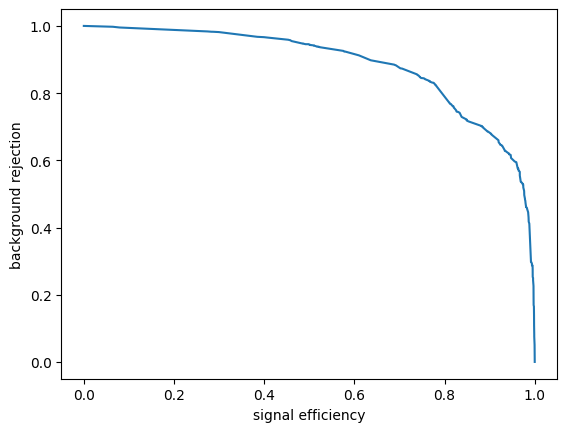

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_val, predictions_bdt, sample_weight=w_val)

plt.plot(tpr, 1-fpr)
plt.xlabel('signal efficiency')
plt.ylabel('background rejection')

The area under the ROC-curve (AUC) value is often used to express the ROC curve in a single metric.
The larger |AUC-0.5| is, the better is the classifier. An AUC score of 0.5 corresponds to a classifier which is randomly guessing.
In the following, we compute the AUC value for the trained BDT.

In [31]:
auc = roc_auc_score(y_val, predictions_bdt, sample_weight=w_val)

print('AUC:', auc)

AUC: 0.8859408195526838


In the Higgs Challenge, the evaluation metric was not the AUC value but the approximate median significance (AMS).
It is defined as:

$$
AMS = \sqrt{2((s+b+b_r) \log(1+\frac{s}{s+b_r})-s)}
$$

Here:
- $s, b$: unnormalised true positive and false positive rates, respectively
- $b_r = 10$ is the constant regularisation term

We will use here an approximation of this metric.

In [32]:
def ams_score(x, y, w, cut):
# Calculate Average Mean Significane as defined in ATLAS paper
#    -  approximative formula for large statistics with regularisation
# x: array of truth values (1 if signal)
# y: array of classifier result
# w: array of event weights
# cut
    t = y > cut 
    s = np.sum((x[t] == 1)*w[t])
    b = np.sum((x[t] == 0)*w[t])
    return s/np.sqrt(b+10.0)

def find_best_ams_score(x, y, w):
# find best value of AMS by scanning cut values; 
# x: array of truth values (1 if signal)
# y: array of classifier results
# w: array of event weights
#  returns 
#   ntuple of best value of AMS and the corresponding cut value
#   list with corresponding pairs (ams, cut) 
# ----------------------------------------------------------
    ymin=min(y) # classifiers may not be in range [0.,1.]
    ymax=max(y)
    nprobe=200    # number of (equally spaced) scan points to probe classifier 
    amsvec= [(ams_score(x, y, w, cut), cut) for cut in np.linspace(ymin, ymax, nprobe)] 
    maxams=sorted(amsvec, key=lambda lst: lst[0] )[-1]
    return maxams, amsvec

In [33]:
prob_bdt = bdt.predict_proba(x_val)[:, 1]
bs = find_best_ams_score(y_val, prob_bdt, w_val)
print('AMS:', bs[0][0])

AMS: 0.2704991507843672


The score is only around 0.25. Far away from the record of 3.81 which was obtained in the Higgs Challenge.
The main reason for the low score is that the dataset used here corresponds only to 10% of the original data. Additionally, the validation dataset is only about 20% of that.
Therefore, the score can be safely scaled up by a factor $\sqrt{50}$.

To give an example of another classifier we will train and evaluate here a [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html).

In [34]:
from sklearn.ensemble import GradientBoostingClassifier as GBC

gbc = GBC(n_estimators=50, max_depth=5,min_samples_leaf=200,verbose=0)
gbc.fit(x_train, y_train)

pred_gbc_val = gbc.predict_proba(x_val)[:, 1]

auc = roc_auc_score(y_val, pred_gbc_val, sample_weight=w_val)
print('AUC:', auc)

bs = find_best_ams_score(y_val, pred_gbc_val, w_val)
print('AMS:', bs[0][0])

AUC: 0.9057780576461775
AMS: 0.2988251450905393


Let's also take a look at the output distribution of the classifier for signal and background.

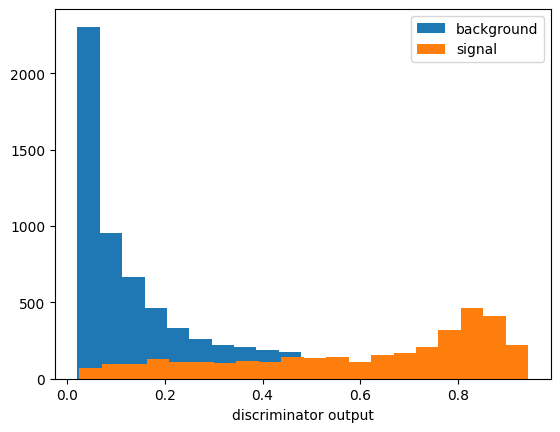

In [35]:
h_b = plt.hist(pred_gbc_val[y_val==0], bins=20, label='background')
h_s = plt.hist(pred_gbc_val[y_val==1], bins=20, label='signal')
plt.xlabel('discriminator output')
plt.legend()

The next model we will train is a neural network using [tensorflow](https://www.tensorflow.org/) and [keras](https://keras.io/).

In [42]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import AUC

Using the keras API, models can be defined via the [Sequential](https://keras.io/api/models/sequential/) or [functional](https://keras.io/guides/functional_api/) API.
The following gives an example of a model defined via the functional API.

In [43]:
def create_model():
    inputs = Input((x_train.shape[1],))
    x = Dense(len(input_columns),activation='tanh')(inputs)
    x = Dense(32, activation='tanh')(x)   
    out = Dense(1, activation='sigmoid')(x)
    return Model(inputs, out)
    

To build more sophisticated models you can make yourself familiar with the different layers and activation [available](https://keras.io/api/layers/) in keras.

In [44]:
model = create_model()

The model is compiled using the [binary_crossentropy](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class) loss function and the [Adam](https://keras.io/api/optimizers/adam/) optimizer.

In [45]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy', AUC()])

During the training it is also useful to use some [callbacks](https://keras.io/api/callbacks/). The [CSVLogger](https://keras.io/api/callbacks/csv_logger/) will write the training and validation losses as well as the metrics specified in the compile statement into a file at each epoch. The [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) callback will save the model to a file so it can be used later for inference. The [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) callback will stop the training if the validation loss doesn't improve for 10 epochs.

In [47]:
callbacks = [
    ModelCheckpoint(filepath='model.keras', save_best_only=True),
    CSVLogger('training.log'),
    EarlyStopping(patience=10)
]

The model is trained using the [fit](https://keras.io/api/models/model_training_apis/#fit-method) method. If you want to watch the training progress, you can set verbose=1.

In [48]:
history = model.fit(x_train, y_train, batch_size=1000, epochs=20, validation_split=0.2, sample_weight=w_train, 
                    callbacks=callbacks, verbose=0)

After training a neural network, it is a good idea to inspect the training and validation loss values as a function of the training epochs. This can help to quickly identify problems during the training. For example an overtraining effect would show itself by an increasing validation loss and a decreasing training loss.

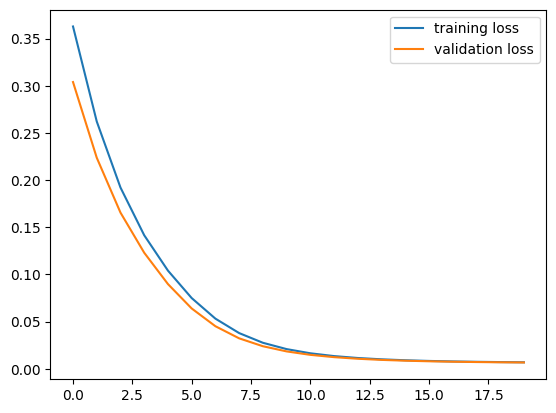

In [49]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.legend()

Using the [predict](https://keras.io/api/models/model_training_apis/#predict-method) method we can apply the trained model to the validation dataset and compute the AUC value and AMS score.

In [51]:
model = load_model('model.keras') #load the best model

pred_val_nn = model.predict(x_val)
auc = roc_auc_score(y_val, pred_val_nn, sample_weight=w_val)

print('AUC:', auc)

y_pred = pred_val_nn.reshape((pred_val_nn.shape[0],))

bs = find_best_ams_score(y_val, y_pred, w_val)
print('AMS:', bs[0][0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
AUC: 0.7810362451400362
AMS: 0.16490001477250074


**Your turn** (obligatory)

Now it is time to work on improvements.
Inspect all the variables in the tree and their correlations.
Which of them show the most prominent differences between signal and background?
Which of them are not so relevant? 
Summarise your ideas and collect some of the graphs for your documentation. 

You should implement code to produce some figures of the distribution of one or more highly-discriminating variables
(e.g. the reconstructed Higgs boson mass `DER_mass_MMC`),
after applying a cut on the classifier corresponding to the best performance.
A Higgs-signal may then become visible in a single distribution.

**Be creative!** (obligatory)

This is the most challenging, but also most rewarding
part of the project. Develop, discuss, test and improve
ideas to increase the performance of your classification.
Consult the documentations of the different ML-libraries (https://scikit-learn.org/ or https://keras.io/) to get inspiration
on options to try out, or clever combinations of
variables to play with or implement your own variables. It`s really a creative process,
without any further prescription ...

**Run it on the full dataset Higgs Challenge** (voluntary)

If you are convinced of your improved classifier,
you may run it on the full data set of the challenge,
prepared for you in a compatible `.root` file

    atlas-higgs-challenge-2014-v2.root

the source of which is given on the `Higgschallenge.pdf`.

It will take some time, but after some hours of invested CPU time, you will be rewarded with your personal score for the Higgs Challenge 2014!

In [1]:
import numpy as np

In [14]:
x = np.random.rand(20)
y = np.random.rand(20)
x

array([0.78903313, 0.07028177, 0.72688111, 0.62313696, 0.53200462,
       0.30895278, 0.84785744, 0.50522559, 0.24702694, 0.80304502,
       0.01415762, 0.7689159 , 0.42044871, 0.14031495, 0.80867752,
       0.51238851, 0.54720066, 0.55599125, 0.83173425, 0.28252582])

In [16]:
tf.round(np.random.rand(5))

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0., 1., 1., 0., 1.])>

In [11]:
x = np.round(x)
y = np.round(y)
x

array([0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0.])

In [13]:
import tensorflow as tf

2024-07-25 20:14:01.219643: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-25 20:14:01.220500: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 20:14:01.224048: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 20:14:01.276405: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 20:14:02.085884: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF